# **Packeges**

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# **Input Images**

In [39]:
image_paths = [
    "/content/drive/MyDrive/SIFT_IMG/img1a_septoria leaf spot.jpg",
    "/content/drive/MyDrive/SIFT_IMG/img1b_septoria leaf spot.jpg",
    "/content/drive/MyDrive/SIFT_IMG/img3a.jpg",
    "/content/drive/MyDrive/SIFT_IMG/img3b.jpg"
]

In [55]:
NUM_OCTAVES = 4
NUM_SCALES = 4
images = []
for path in image_paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(gray)


# **Gaussian Pyramid**

In [46]:
def build_gaussian_pyramid(img, num_octaves=4, num_scales=4):
    pyramid = []
    for o in range(num_octaves):
        octave = []
        for s in range(num_scales):
            sigma = 1.6 * (2 ** (s / num_scales))
            blurred = cv2.GaussianBlur(img, (0, 0), sigma)
            octave.append(blurred)
        pyramid.append(octave)
        img = cv2.pyrDown(img)  # next octave downsample
    return pyramid

gauss_pyramids = [build_gaussian_pyramid(img, NUM_OCTAVES, NUM_SCALES) for img in images]


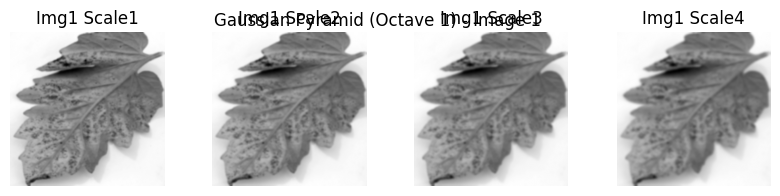

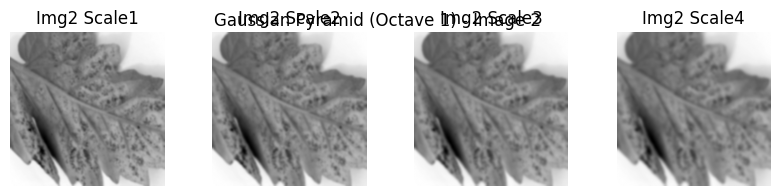

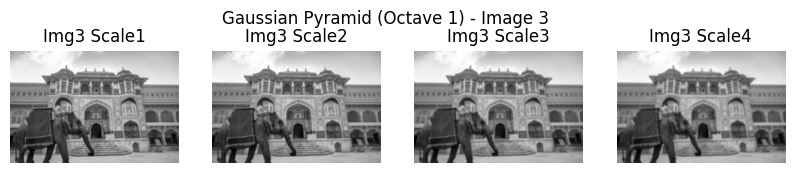

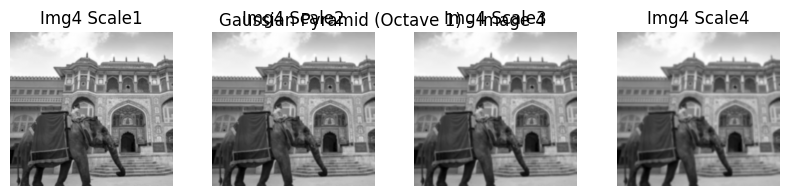

In [56]:
for i, pyramid in enumerate(gauss_pyramids):
    plt.figure(figsize=(10, 2))
    for j, level in enumerate(pyramid[0]):  # display first octave
        plt.subplot(1, NUM_SCALES, j+1)
        plt.imshow(level, cmap='gray')
        plt.title(f"Img{i+1} Scale{j+1}")
        plt.axis('off')
    plt.suptitle(f"Gaussian Pyramid (Octave 1) - Image {i+1}")
    plt.show()

# **DOG Pyramid**

In [57]:
def build_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = []
        for i in range(1, len(octave)):
            dog = cv2.subtract(octave[i], octave[i-1])
            dog_octave.append(dog)
        dog_pyramid.append(dog_octave)
    return dog_pyramid

dog_pyramids = [build_dog_pyramid(p) for p in gauss_pyramids]

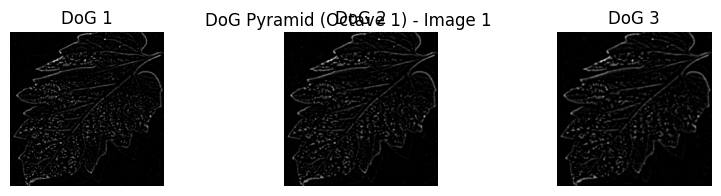

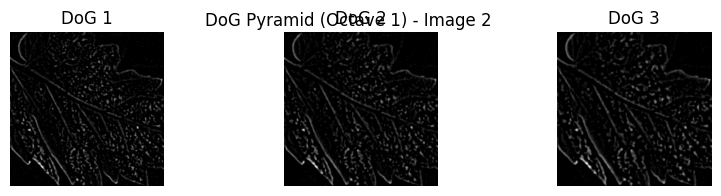

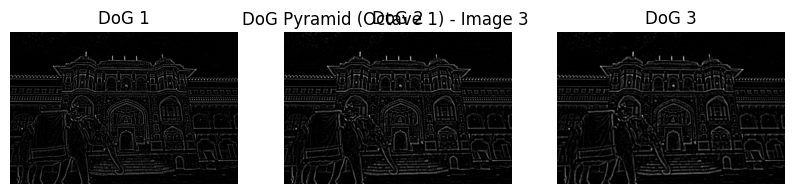

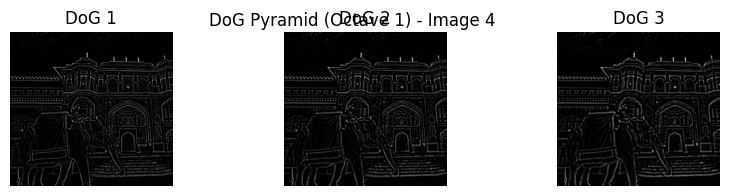

In [58]:
for i, pyramid in enumerate(dog_pyramids):
    plt.figure(figsize=(10, 2))
    for j, level in enumerate(pyramid[0]):  # show first octave
        plt.subplot(1, NUM_SCALES-1, j+1)
        plt.imshow(level, cmap='gray')
        plt.title(f"DoG {j+1}")
        plt.axis('off')
    plt.suptitle(f"DoG Pyramid (Octave 1) - Image {i+1}")
    plt.show()

# **Keypoints**

[Image 1] Keypoints detected: 806


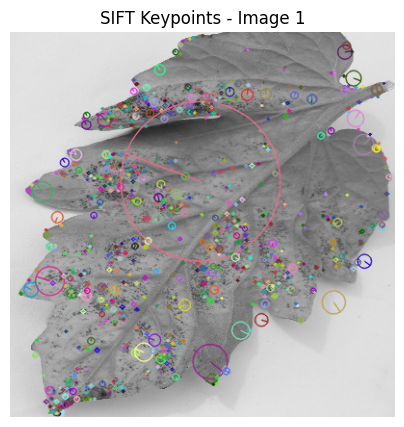

[Image 2] Keypoints detected: 680


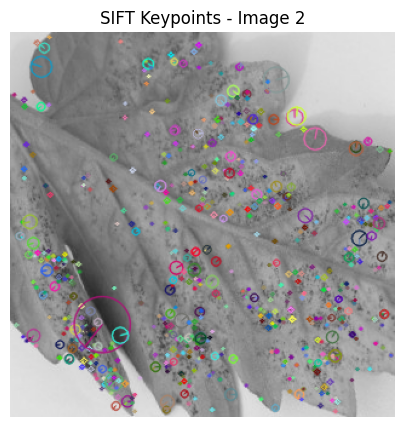

[Image 3] Keypoints detected: 4795


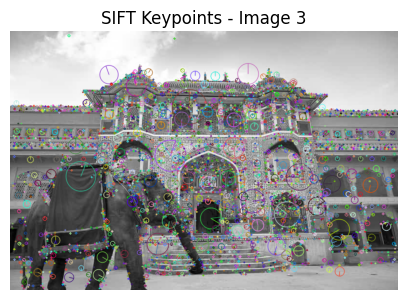

[Image 4] Keypoints detected: 3623


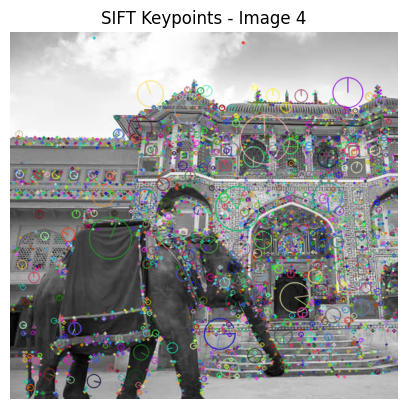

In [50]:
sift = cv2.SIFT_create(nOctaveLayers=NUM_SCALES)

keypoints_all = []
descriptors_all = []

for i, img in enumerate(images):
    keypoints, descriptors = sift.detectAndCompute(img, None)
    keypoints_all.append(keypoints)
    descriptors_all.append(descriptors)
    print(f"[Image {i+1}] Keypoints detected: {len(keypoints)}")

    #keypoints visualisation
    img_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_kp[..., ::-1])
    plt.title(f"SIFT Keypoints - Image {i+1}")
    plt.axis('off')
    plt.show()

# **Matching**

[Match 1-2] Total matches: 806 | Good matches: 395


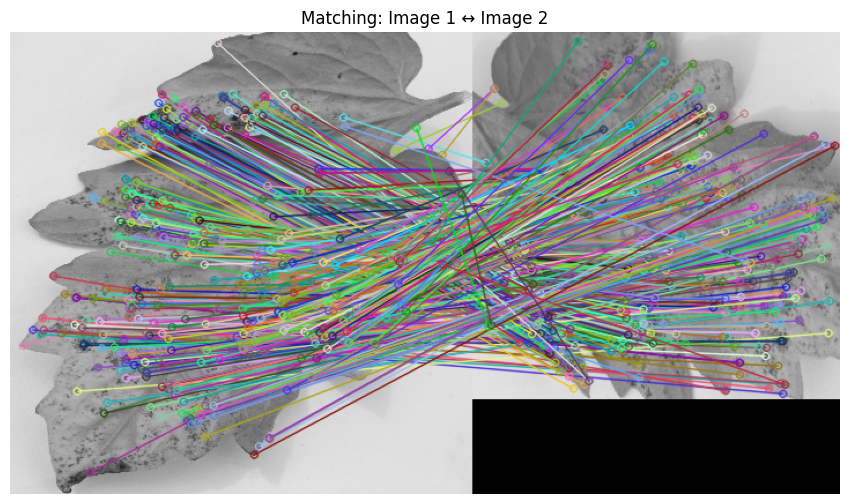

[Match 2-3] Total matches: 680 | Good matches: 4


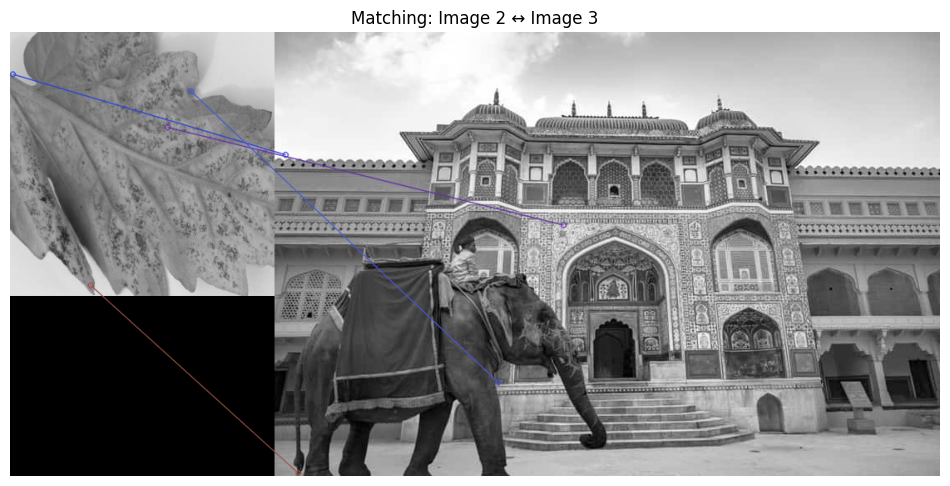

[Match 3-4] Total matches: 4795 | Good matches: 3327


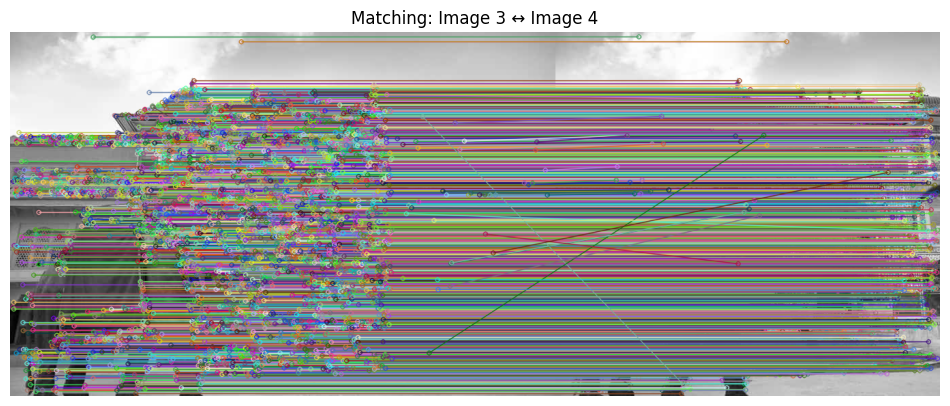

In [59]:
bf = cv2.BFMatcher()
for i in range(0, len(images)-1):
    matches = bf.knnMatch(descriptors_all[i], descriptors_all[i+1], k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    print(f"[Match {i+1}-{i+2}] Total matches: {len(matches)} | Good matches: {len(good)}")

    img_matches = cv2.drawMatchesKnn(
        images[i], keypoints_all[i],
        images[i+1], keypoints_all[i+1],
        good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches[..., ::-1])
    plt.title(f"Matching: Image {i+1} ↔ Image {i+2}")
    plt.axis('off')
    plt.show()

# **Analysis**

In [61]:
print("REPORT")
for i, (kp, desc) in enumerate(zip(keypoints_all, descriptors_all)):
    print(f"Image {i+1}:")
    print(f"  - Keypoints: {len(kp)}")
    print(f"  - Descriptor size: {desc.shape if desc is not None else 'N/A'}")
    print(f"  - Gaussian pyramid octaves: {len(gauss_pyramids[i])}")
    print(f"  - DoG images per octave: {len(dog_pyramids[i][0])}")
    print("----------------------------------------")

REPORT
Image 1:
  - Keypoints: 806
  - Descriptor size: (806, 128)
  - Gaussian pyramid octaves: 4
  - DoG images per octave: 3
----------------------------------------
Image 2:
  - Keypoints: 680
  - Descriptor size: (680, 128)
  - Gaussian pyramid octaves: 4
  - DoG images per octave: 3
----------------------------------------
Image 3:
  - Keypoints: 4795
  - Descriptor size: (4795, 128)
  - Gaussian pyramid octaves: 4
  - DoG images per octave: 3
----------------------------------------
Image 4:
  - Keypoints: 3623
  - Descriptor size: (3623, 128)
  - Gaussian pyramid octaves: 4
  - DoG images per octave: 3
----------------------------------------


# **Robustness- Using Transformation (scaling, rotation, illumination)**

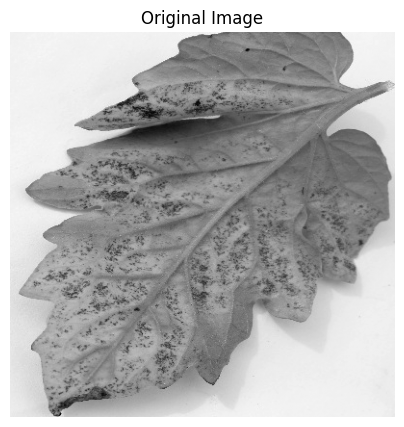

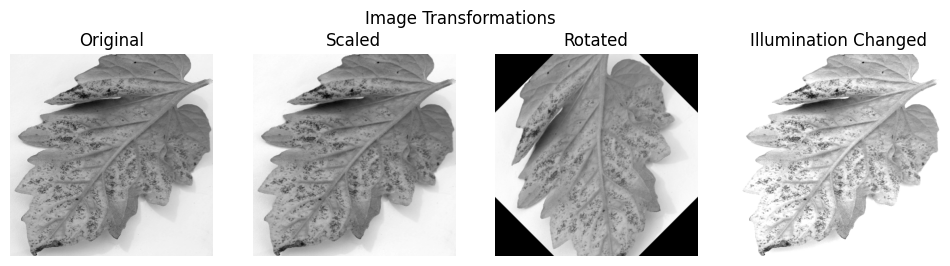

[Original ↔ Scaled] Total matches: 698 | Good matches: 323


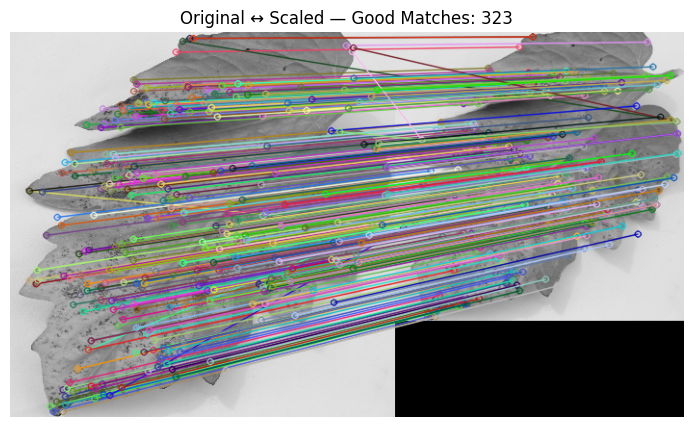

[Original ↔ Rotated] Total matches: 698 | Good matches: 406


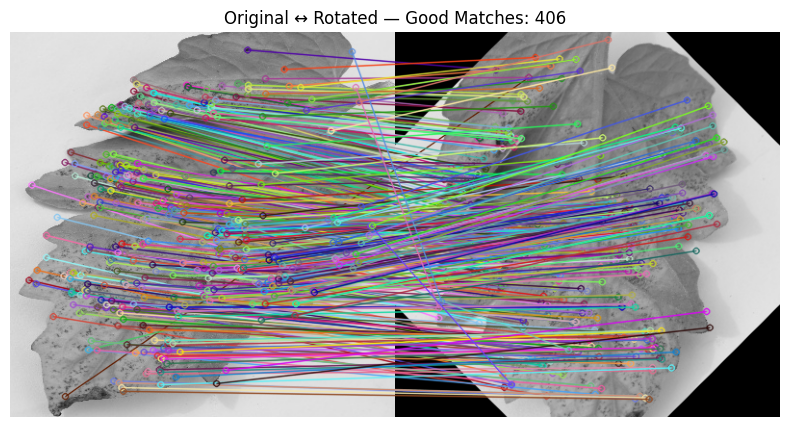

[Original ↔ Illumination Changed] Total matches: 698 | Good matches: 580


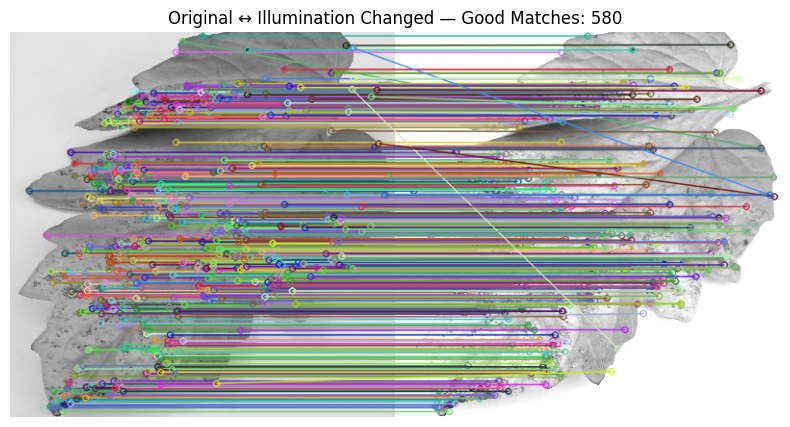

SIFT TRANSFORMATION REPORT
Original image keypoints: 698
Scaled image keypoints: 453 | Good matches: 323
Rotated image keypoints: 682 | Good matches: 406
Illumination-changed image keypoints: 1165 | Good matches: 580

Matching Ratios (relative to original):
Scale change: 0.46
Rotation change: 0.58
Illumination change: 0.83


In [67]:
image_path = "/content/drive/MyDrive/SIFT_IMG/img1a_septoria leaf spot.jpg"
scale_factor = .75         # scale up by .75×
rotation_angle = 45        # rotate 45 degrees
illumination_gain = 1.5    # brightness gain

img_color = cv2.imread(image_path)

gray_original = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5,5))
plt.imshow(gray_original, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


# application of transformation

# Scaling
scaled_img = cv2.resize(gray_original, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

# Rotation
(h, w) = gray_original.shape
center = (w//2, h//2)
rot_mat = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
rotated_img = cv2.warpAffine(gray_original, rot_mat, (w, h))

# Illumination change
illum_img = cv2.convertScaleAbs(gray_original, alpha=illumination_gain, beta=0)


titles = ["Original", "Scaled", "Rotated", "Illumination Changed"]
imgs = [gray_original, scaled_img, rotated_img, illum_img]

plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.suptitle("Image Transformations")
plt.show()


sift = cv2.SIFT_create()

# keypoints & descriptors
kps_orig, desc_orig = sift.detectAndCompute(gray_original, None)
kps_scaled, desc_scaled = sift.detectAndCompute(scaled_img, None)
kps_rot, desc_rot = sift.detectAndCompute(rotated_img, None)
kps_illum, desc_illum = sift.detectAndCompute(illum_img, None)



# MATCHING FUNCTION

def match_and_draw(img1, kp1, desc1, img2, kp2, desc2, title):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
    print(f"[{title}] Total matches: {len(matches)} | Good matches: {len(good)}")

    img_match = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.imshow(img_match[..., ::-1])
    plt.title(f"{title} — Good Matches: {len(good)}")
    plt.axis('off')
    plt.show()

    return len(good)


#  Comparison orginal vs transformed

match_scale = match_and_draw(gray_original, kps_orig, desc_orig, scaled_img, kps_scaled, desc_scaled, "Original ↔ Scaled")
match_rot = match_and_draw(gray_original, kps_orig, desc_orig, rotated_img, kps_rot, desc_rot, "Original ↔ Rotated")
match_illum = match_and_draw(gray_original, kps_orig, desc_orig, illum_img, kps_illum, desc_illum, "Original ↔ Illumination Changed")

#Report

print("SIFT TRANSFORMATION REPORT")
print(f"Original image keypoints: {len(kps_orig)}")
print(f"Scaled image keypoints: {len(kps_scaled)} | Good matches: {match_scale}")
print(f"Rotated image keypoints: {len(kps_rot)} | Good matches: {match_rot}")
print(f"Illumination-changed image keypoints: {len(kps_illum)} | Good matches: {match_illum}")

# match ratios
ratio_scale = match_scale / max(len(kps_orig), 1)
ratio_rot = match_rot / max(len(kps_orig), 1)
ratio_illum = match_illum / max(len(kps_orig), 1)

print("\nMatching Ratios (relative to original):")
print(f"Scale change: {ratio_scale:.2f}")
print(f"Rotation change: {ratio_rot:.2f}")
print(f"Illumination change: {ratio_illum:.2f}")



# **Stitching**

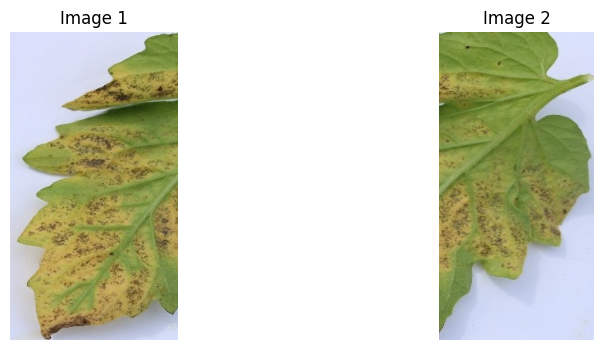

Keypoints - Image1: 451, Image2: 228


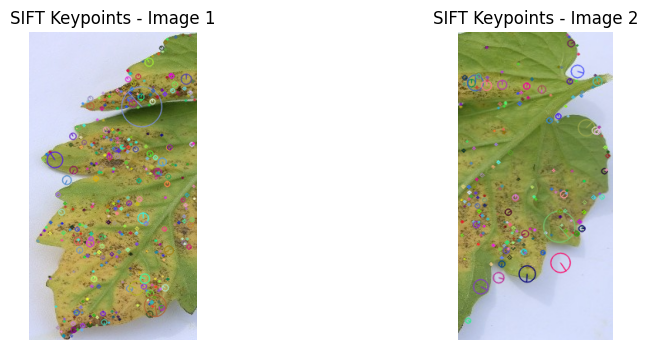

Good matches found: 7


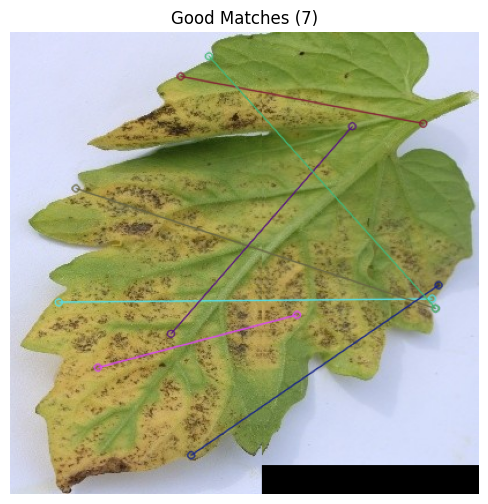

Homography matrix:
[[ 2.09957959e-01 -6.83133360e-01  1.86561583e+02]
 [-8.70407085e-02 -3.13719290e-01  1.33119874e+02]
 [ 3.55093400e-03 -3.87402812e-03  1.00000000e+00]]


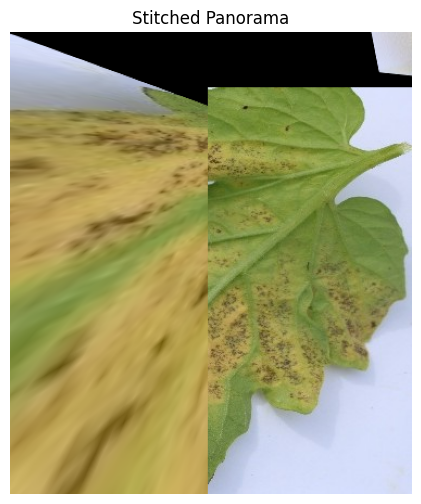

Image 1 keypoints: 451
Image 2 keypoints: 228
Good matches used: 7


In [70]:

img1_path = "/content/drive/MyDrive/SIFT_IMG/stitch1.jpg"
img2_path = "/content/drive/MyDrive/SIFT_IMG/stitch2.jpg"

img1_color = cv2.imread(img1_path)
img2_color = cv2.imread(img2_path)

img1_gray = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2_color, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.axis("off")
plt.show()


sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

print(f"Keypoints - Image1: {len(kp1)}, Image2: {len(kp2)}")

# keypoints
img1_kp = cv2.drawKeypoints(img1_color, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2_color, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints - Image 1")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints - Image 2")
plt.axis("off")
plt.show()


# STEP 3: MATCH FEATURES USING BFMatcher + RATIO TEST

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Good matches found: {len(good_matches)}")

# Visualize good matches
match_img = cv2.drawMatches(
    img1_color, kp1,
    img2_color, kp2,
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title(f"Good Matches ({len(good_matches)})")
plt.axis("off")
plt.show()

#homography
if len(good_matches) > 4:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Estimate homography with RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    print(f"Homography matrix:\n{H}")
else:
    raise ValueError("Not enough matches to compute homography.")


# Warp
h1, w1 = img1_color.shape[:2]
h2, w2 = img2_color.shape[:2]

#corners of image1
corners_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
warped_corners = cv2.perspectiveTransform(corners_img1, H)
corners_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)


all_corners = np.concatenate((warped_corners, corners_img2), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

# Translation matrix
translation = np.array([[1, 0, -x_min],
                        [0, 1, -y_min],
                        [0, 0, 1]])

# Warp image 1
result = cv2.warpPerspective(img1_color, translation @ H, (x_max - x_min, y_max - y_min))
# Paste image 2
result[-y_min:h2 - y_min, -x_min:w2 - x_min] = img2_color


plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Stitched Panorama")
plt.axis("off")
plt.show()


cv2.imwrite("stitched_result.jpg", result)


# Report summary

print(f"Image 1 keypoints: {len(kp1)}")
print(f"Image 2 keypoints: {len(kp2)}")
print(f"Good matches used: {len(good_matches)}")
